## 데이터 구하기

In [5]:
import requests
import os

url = "https://query1.finance.yahoo.com/v7/finance/download/NQ=F?period1=969235200&period2=1603152000&interval=1d&events=history&includeAdjustedClose=true"
response = requests.get(url)
csv_file = 'data/csv/Nasdaq.csv'

with open(csv_file, "w") as fp:  
    fp.write(response.text)

In [7]:
import pandas as pd
df = pd.read_csv(csv_file)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0
2,2000-09-20,3801.5,3874.0,3715.5,3853.0,3853.0,78832.0
3,2000-09-21,3852.0,3874.0,3744.0,3765.0,3765.0,70719.0
4,2000-09-22,3673.0,3780.0,3615.0,3776.0,3776.0,55926.0


In [10]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

1072개가 되는 결측치가 있는 것을 확인했습니다. dropna 함수를 이용해 결측치를 제거합니다. 

In [11]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6166
삭제 후 데이터 길이(일자수): 5094


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

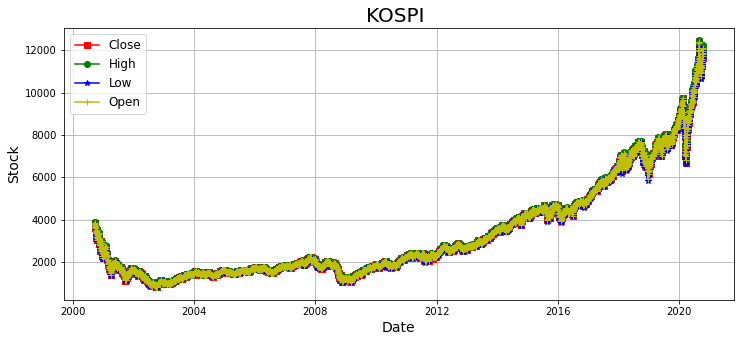

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')
plt.grid(True)
plt.show()

그래프로 시각화한 결과 눈에 띄는 이상치는 발견되지 않았습니다. 너무 색이 겹쳐보여서 4개의 그래프를 따로 보기 어려워 보입니다. 각기 어떤 관계를 가지고 있는 지 알기 위해 확대해 보겠습니다.  

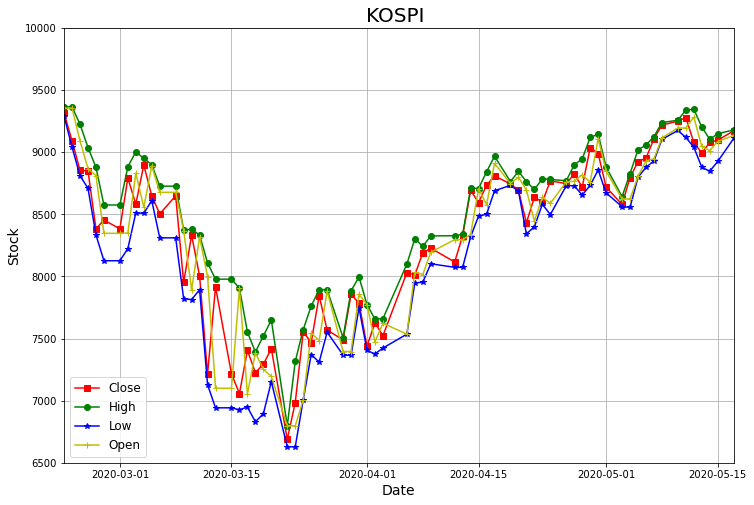

In [56]:
plt.rcParams["figure.figsize"] = (12,8)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')
plt.grid(True)
plt.ylim(6500, 10000)
plt.xlim(df.Date[4900], df.Date[4970])
plt.show()

앞선 그래프 보다 4개의 특성들의 관계를 확인 하는데 좋은 것 같습니다. 

## 기본 통계분석으로 이상치 찾기

In [57]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

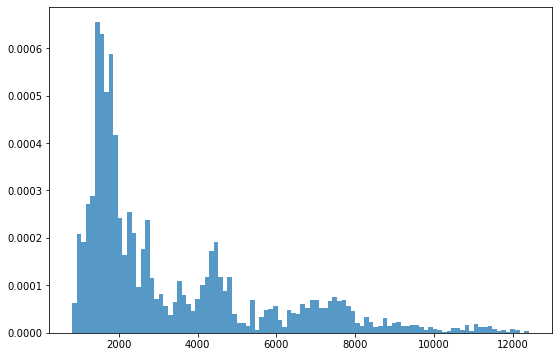

In [58]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

위의 그래프는 주식의 종가의 데이터 분포를 시각화한 모습입니다. 한눈에 봐도 정규분포와는 멀어보이지만, z-test로 확실한 비교를 해보겠습니다. 

In [59]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


역시 기본 raw 데이터는 정규분포로 나오기는 힘든 것 같습니다. 정규분포에 가까운 데이터를 추출하기 위해서 Time series decomposition 방법을 사용하겠습니다. 

### Time series decompose

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정

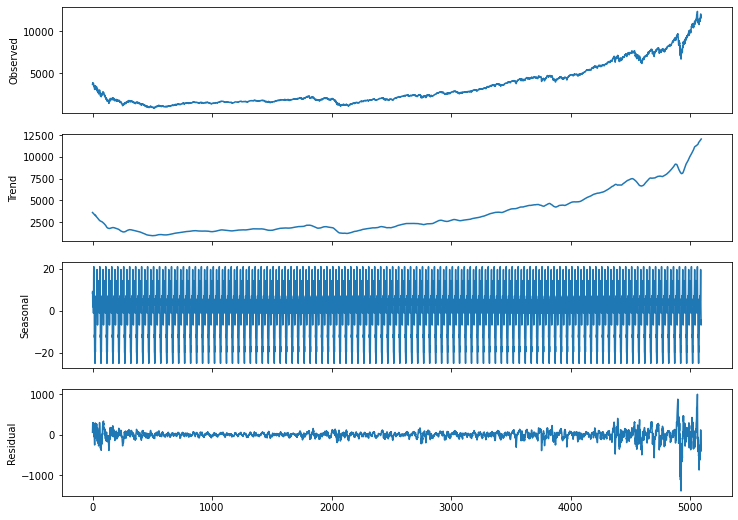

In [64]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

이렇게 Time series decompose를 하는 이유는 Trend와 Seasonal을 뽑아내고 남은 resid가 큰날은 뭔가 일반적인 흐름에서 벗어난 날로 해석될 수 있기 때문이다. 

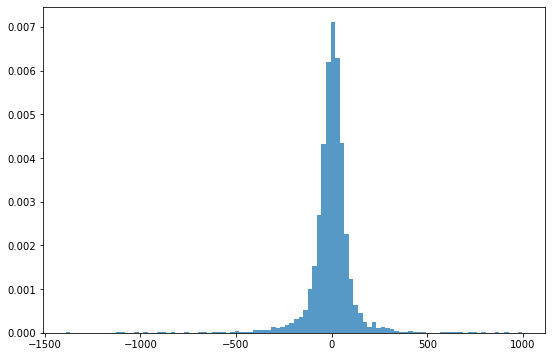

In [66]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [67]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8942734929026214 0.37117557875831597


residual의 분포를 그려보고 z-test를 통해 숫자를 확인해보니 p-value가 0.05 이상으로 아주 강하게 나타남을 확인 할 수 있었습니다. 

### 3σ 기준 신뢰구간으로 이상치 찾기

In [70]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.3857940518773482 표준편차: 110.60068205120815
이상치 갯수: 93


In [112]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5086   2020-10-08
5093   2020-10-19
Name: Date, Length: 93, dtype: datetime64[ns]

5094개의 데이터 샘플 중에서 93개는 이상치라는 사실을 확인했습니다. 그럼 탐지해낸 Anomalies는 Outlier인지, Novelties인지 구분해야 합니다. 하지만 대충 코로나나 대공황 때문이라고 예측할 수 있지만, 확실하게 주장할 수는 없습니다.

##  Unsupervised Clustering 으로 이상치 찾기

### 데이터 전처리

In [93]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,3324.303285,3355.663089,3292.204015,3326.157530,287799.789978
std,2390.871506,2412.479986,2369.858940,2394.718369,109505.235488
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.251875,1597.572500,1571.058750,1584.191100,220550.460000
50%,2263.775000,2291.211250,2231.463750,2264.287900,268829.760000
75%,4433.603750,4464.010625,4399.788125,4434.981250,319616.697500
max,12064.786259,12214.296509,11897.172140,12066.724264,776809.340000


In [114]:
sdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-0.008616,-0.006603,-0.011572,-0.009202,22.286330
std,11.597437,10.750511,12.297973,11.536247,14557.355693
min,-25.636086,-26.520436,-28.644252,-25.083118,-35905.398752
25%,-6.213432,-6.863078,-9.306915,-6.951926,-11576.678563
50%,2.283903,2.699136,2.467976,2.210146,-513.736640
75%,6.669267,6.280691,8.062987,6.577663,10226.500457
max,22.521422,20.130833,20.358573,20.989196,34534.955255


In [113]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-1.494218,-1.447168,-1.394948,-1.402187,132.899742
std,113.106458,102.570229,117.278403,110.763008,110724.899203
min,-1280.163546,-1494.231533,-1226.595518,-1389.770659,-603014.586328
25%,-37.912202,-35.100432,-38.323649,-37.371552,-53397.033973
50%,3.575670,3.350366,4.153527,2.958782,-584.124075
75%,40.353926,37.613888,42.048756,40.813609,51481.304420
max,996.821566,933.584382,941.409836,996.232816,810690.898648


In [115]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.49421837  -1.44716848  -1.39494753  -1.40218679 132.89974227]


array([[ 0.94173218,  0.84218124,  0.81160865,  0.59799575,  0.083212  ],
       [ 0.48655464,  1.27770882,  1.3787828 ,  2.08212326,  0.10453018],
       [ 1.89305329,  2.00817542,  2.03390849,  2.72037058, -0.08887086],
       ...,
       [-0.65531897, -1.82608069, -0.96473553, -1.32833825,  0.28433475],
       [-1.31334711, -1.62375976, -0.70348768, -2.17905108, -0.36419423],
       [-2.12456827, -2.48917183, -2.57191425, -3.70655626, -0.28328824]])

### k-means 로 이상치 탐색하기

In [118]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1038',
 'group:1-count:454',
 'group:2-count:32',
 'group:3-count:106',
 'group:4-count:13',
 'group:5-count:20',
 'group:6-count:74',
 'group:7-count:204',
 'group:8-count:826',
 'group:9-count:442',
 'group:10-count:34',
 'group:11-count:105',
 'group:12-count:337',
 'group:13-count:414',
 'group:14-count:995']

4,5 그룹의 경우 count가 20 이하로 분류된 특이한 그룹입니다. 어떤 날들이 이상치로 분류되었는지 확인해보고 왜 그렇게 분류되었는지 알아보겠습니다.

#### 어떤 날들이 분류된 걸까?

In [129]:
df[(kmeans.labels_==4)]

,Date,Open,High,Low,Close,Adj Close,Volume
4917,2020-03-13,7100.000000,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4918,2020-03-15,7100.000000,7978.000000,6942.500000,7215.250000,7215.250000,578813.0
4919,2020-03-16,7903.000000,7905.250000,6927.000000,7057.500000,7057.500000,307368.0
4920,2020-03-17,7053.000000,7552.250000,6948.750000,7405.250000,7405.250000,317501.0
4921,2020-03-18,7386.000000,7392.250000,6830.000000,7225.250000,7225.250000,156283.0
4922,2020-03-19,7251.750000,7521.500000,6894.250000,7293.500000,7293.500000,115519.0
4923,2020-03-20,7195.000000,7649.000000,7153.500000,7417.979980,7417.979980,562616.0
4924,2020-03-22,6798.000000,6798.000000,6628.750000,6688.750000,6688.750000,321230.0
4925,2020-03-23,6798.000000,7316.250000,6628.750000,6984.500000,6984.500000,633237.0
4926,2020-03-24,7005.750000,7572.250000,7005.750000,7554.750000,7554.750000,556553.0


In [130]:
df[(kmeans.labels_==5)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


In [120]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,3322.800450,3354.209317,3290.797495,3324.746141,3324.746141,2.879550e+05
std,2390.480458,2411.646052,2370.093040,2394.337534,2394.337534,1.593822e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1592.812500,1608.312500,1576.500000,1593.000000,1593.000000,1.906860e+05
50%,2229.625000,2257.375000,2210.750000,2230.250000,2230.250000,2.656720e+05
75%,4445.000000,4464.687500,4417.875000,4448.250000,4448.250000,3.558778e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [127]:
df.iloc[4895:4905]

,Date,Open,High,Low,Close,Adj Close,Volume
4895,2020-02-16,9635.00,9668.75,9634.25,9663.75,9663.75,297278.0
4896,2020-02-18,9635.00,9687.50,9534.25,9636.00,9636.00,668505.0
4897,2020-02-19,9643.25,9748.75,9641.25,9733.50,9733.50,419130.0
4898,2020-02-20,9744.75,9763.00,9517.00,9624.25,9624.25,802424.0
4899,2020-02-21,9617.25,9623.75,9411.50,9458.00,9458.00,911839.0
4900,2020-02-23,9355.25,9365.00,9289.00,9315.00,9315.00,995989.0
4901,2020-02-24,9355.25,9365.00,9041.25,9091.00,9091.00,1171879.0
4902,2020-02-25,9091.00,9224.25,8810.00,8854.25,8854.25,1344897.0
4903,2020-02-26,8868.25,9037.50,8709.50,8850.25,8850.25,1251412.0
4904,2020-02-27,8811.50,8878.50,8334.25,8382.75,8382.75,1580041.0


#### 각 그룹은 어떤 특징을 가지고 있을까?

In [121]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.227474,-0.233726,-0.196266,-0.202156,0.056737
1,0.887822,0.923669,0.957192,0.939782,-0.291426
2,-4.216525,-4.578292,-4.190891,-4.289738,0.564549
3,2.293611,2.380824,2.415479,2.376406,-0.438337
4,-8.262590,-7.541295,-8.315885,-7.407110,-1.791962
5,6.027197,6.084572,6.079186,6.001044,-0.221012
6,-1.181870,-1.306283,-1.849091,-1.821151,2.970848
7,0.423823,0.430877,0.494239,0.494629,-1.930095
8,0.313333,0.342215,0.265388,0.281084,0.463783
9,-0.898808,-0.913748,-0.865116,-0.844427,0.338528


4번 그룹의 경우 Open, High, Low, Close의 값이 유독 낮은 그룹이고,  
5번 그룹의 경우 Open, High, Low, Close의 값이 유독 높은 그룹입니다.  
두 그룹이 서로 상충됨을 알 수 있습니다.

####  왜 이상치로 분류된걸까?

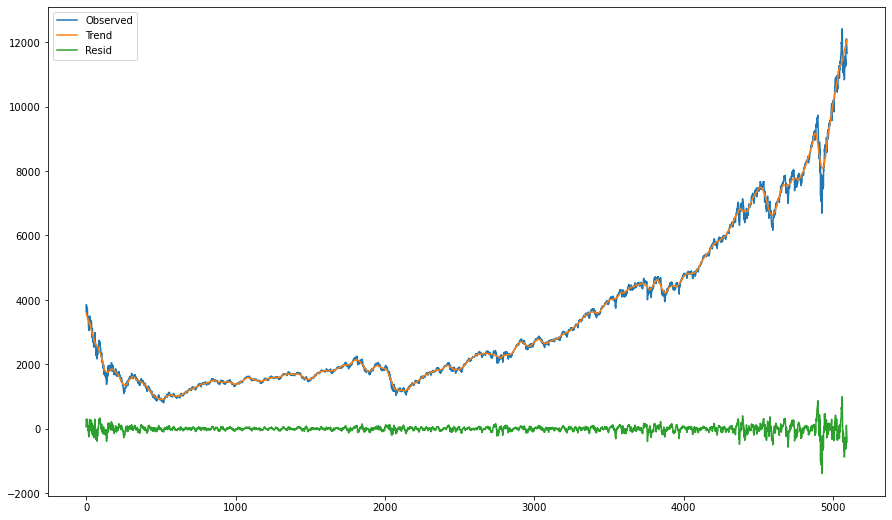

In [124]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

인베스팅 닷컴으로 확인해본 결과 코로나의 영향으로 나스닥은 2020년 3월 23일 최대 낙폭을 기록합니다. 또한 9월에 다시 조정기가 와서 하락하는 추세를 보이고 있습니다. 이러한 하락세를 보이는 데이터는 그룹4에 포함되어 있습니다.  
반면 그룹5는 코로나 이후 혹은 이전에 큰 상승세를 기록하던 데이터의 집합입니다.

### DBSCAN 으로 이상치 찾기

In [183]:
from sklearn.cluster import DBSCAN
columns=df[['Open','High','Low','Close','Volume']]

model = DBSCAN(eps=0.3, min_samples=6)
predict = pd.DataFrame(model.fit_predict(columns))
predict.columns=['predict']

r = pd.concat([columns,predict],axis=1)

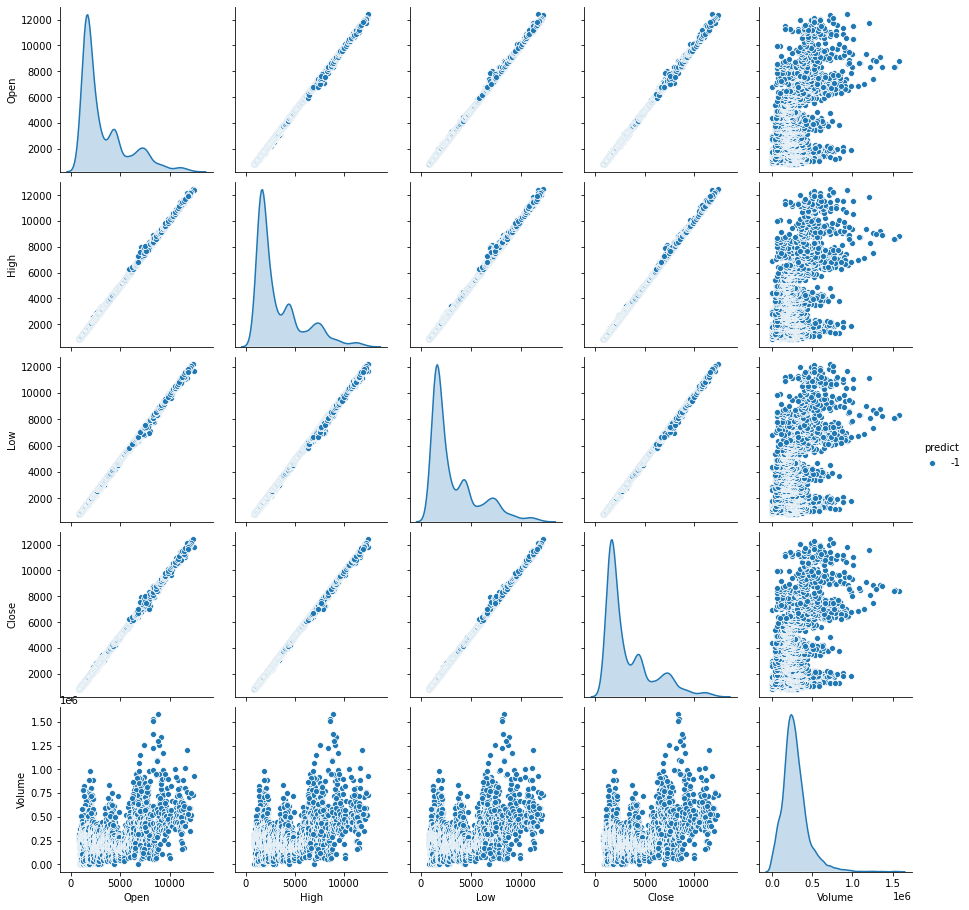

In [189]:
sns.pairplot(r,hue='predict')
plt.show()

In [188]:
clustering = model.fit(norm_rdf)
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:924',
 'group:0-count:4153',
 'group:1-count:10',
 'group:2-count:7']

DBSCAN의 주변공간을 정의하는 데이터 벡터들로 부터의 반경 eps파라미터를 0.3으로 설정하고 최소 개수를 6으로 설정한결과 총 3개의 소수그룹을 생성해냈다.

##  Auto-Encoder를 이용한 이상치 탐색

In [162]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [163]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [164]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [165]:
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [166]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='tanh', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='tanh', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [167]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [168]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
156/159 [============================>.] - ETA: 0s - loss: 1.1324 - mae: 1.1324
Epoch 00001: val_loss improved from inf to 3.02296, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 2s 11ms/step - loss: 1.1287 - mae: 1.1287 - val_loss: 3.0230 - val_mae: 3.0230
Epoch 2/50
156/159 [============================>.] - ETA: 0s - loss: 0.6275 - mae: 0.6275
Epoch 00002: val_loss improved from 3.02296 to 1.15762, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 1s 5ms/step - loss: 0.6214 - mae: 0.6214 - val_loss: 1.1576 - val_mae: 1.1576
Epoch 3/50
156/159 [============================>.] - ETA: 0s - loss: 0.5276 - mae: 0.5276
Epoch 00003: val_loss improved from 1.15762 to 0.92336, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 1s 6ms/step - loss: 0.5222 - mae: 0.5222 - val

Epoch 29/50
151/159 [===========================>..] - ETA: 0s - loss: 0.2898 - mae: 0.2898
Epoch 00029: val_loss improved from 0.36087 to 0.31430, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 1s 5ms/step - loss: 0.2862 - mae: 0.2862 - val_loss: 0.3143 - val_mae: 0.3143
Epoch 30/50
148/159 [==========================>...] - ETA: 0s - loss: 0.2851 - mae: 0.2851
Epoch 00030: val_loss improved from 0.31430 to 0.26502, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 1s 5ms/step - loss: 0.2845 - mae: 0.2845 - val_loss: 0.2650 - val_mae: 0.2650
Epoch 31/50
156/159 [============================>.] - ETA: 0s - loss: 0.2103 - mae: 0.2103
Epoch 00031: val_loss did not improve from 0.26502
159/159 [==============================] - 1s 6ms/step - loss: 0.2121 - mae: 0.2121 - val_loss: 0.5383 - val_mae: 0.5383
Epoch 32/50
149/159 [=======================

In [169]:
model.load_weights(checkpoint_path)

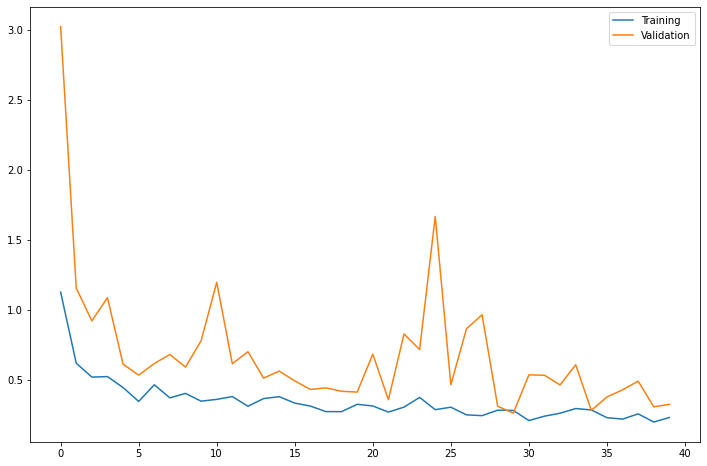

In [170]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

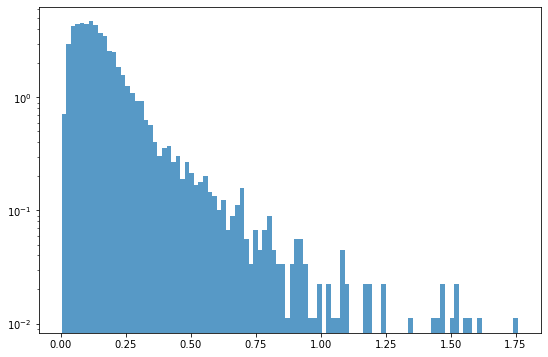

In [171]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

threshold를 1.3으로 두고 그 이상의 값은 이상치라고 가정하겠습니다.

In [173]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4892,2020-02-25,9091.00,9224.250000,8810.000000,8854.250000,8854.250000,1344897.0,1.344479
4894,2020-02-27,8811.50,8878.500000,8334.250000,8382.750000,8382.750000,1580041.0,1.759713
4895,2020-02-28,8347.00,8574.750000,8126.250000,8454.000000,8454.000000,1527204.0,1.523947
4896,2020-03-01,8347.00,8574.750000,8126.250000,8382.750000,8382.750000,1513887.0,1.515770
4897,2020-03-02,8349.25,8883.250000,8224.250000,8791.250000,8791.250000,1373357.0,1.561767
4898,2020-03-03,8830.50,9002.500000,8511.000000,8582.500000,8582.500000,1295648.0,1.473361
4920,2020-03-29,7395.75,7507.250000,7367.250000,7489.250000,7489.250000,1256384.0,1.456975
4930,2020-04-12,8296.00,8327.500000,8073.250000,8115.750000,8115.750000,1224003.0,1.468118
5051,2020-09-02,12325.50,12465.200195,12172.200195,12411.500000,12411.500000,725395.0,1.580030
5052,2020-09-03,12408.50,12438.799805,11658.500000,11800.500000,11800.500000,931583.0,1.614321


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


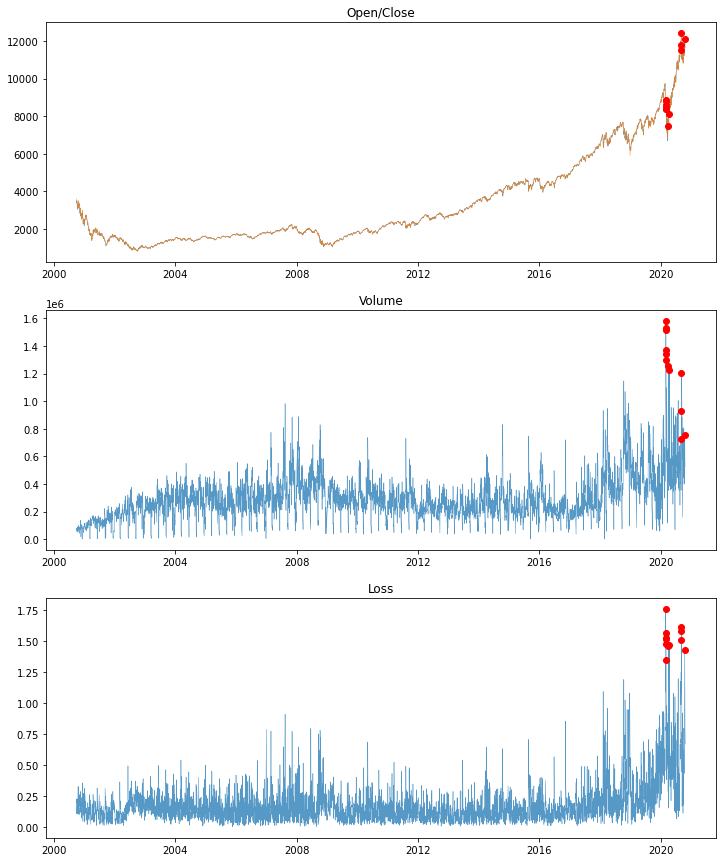

In [174]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

이상치들을 붉은 점으로 나타내고 그래프로 그려본 결과 최대 낙폭지점과, 최대 상승 지점에서 빨간 점이 보입니다. 이는 outlier라고 하기 보다 특이치라고 보는게 적당한 것 같습니다.

## Report

앞선 두가지 방법은 Unsupervised Clustering을 활용하여 군집을 형성하고 소수의 집합을 이상치로 가정하는 방법이었습니다. 적은 샘플로도 이상치를 분리할 수 있다는 장점이 있지만, 데이터의 안정성을 위해서 Time series decomposition 분석이 추가되는 단점이 있습니다.  
오터인코더 모델에서는 decomposition을 하지 않고도 간단한 데이터 전처리만을 수행하면 되는 장점이 있습니다. 그리고 모델을 변형시켜서 좀 더 나은 성능을 낼 수도 있습니다. 

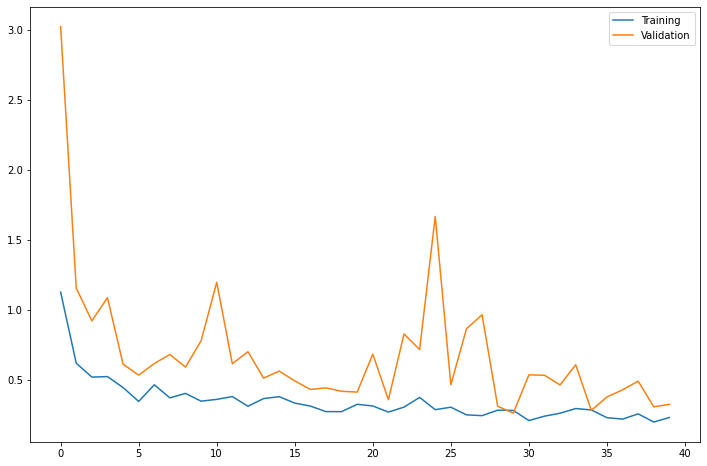

In [175]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()